In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [3]:
# Train-test split

train_size = int(len(df) * 0.8) 

train_df,test_df = df[1:train_size], df[train_size:] 

In [4]:
test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [5]:
# Scaling

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [6]:
# Now we will make a function that will use a sliding window approach to transform our series into samples 
# of input past observations and output future observations to use supervised learning algorithms.

# FUNCTION
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [11]:
# Convert train and test data:

# Variables
n_past = 60
n_future = 136
n_features = 6

# CALLS
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [12]:
X_train.shape

(604, 60, 6)

In [13]:
X_test.shape

(5, 60, 6)

In [14]:
y_train.shape

(604, 136, 6)

In [15]:
y_test.shape

(5, 136, 6)

# Multivariate model

In [16]:
# Doesn't work like this but technically its the same as the stuff below (?) -- For simplicity look at this

# Model 1: E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [17]:
# E1D1
# n_features ==> no of features at each timestep in the data.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.Huber())

history = model.fit(
                    X_train, y_train, 
                    batch_size=256, 
                    epochs=100, 
                    validation_data=(X_test,y_test)
                   )

Epoch 1/100
3/3 [==============================] - 1s 498ms/step - loss: 0.1826 - val_loss: 0.2354
Epoch 2/100
3/3 [==============================] - 1s 246ms/step - loss: 0.1817 - val_loss: 0.2340
Epoch 3/100
3/3 [==============================] - 1s 249ms/step - loss: 0.1810 - val_loss: 0.2331
Epoch 4/100
3/3 [==============================] - 1s 256ms/step - loss: 0.1802 - val_loss: 0.2321
Epoch 5/100
3/3 [==============================] - 1s 249ms/step - loss: 0.1794 - val_loss: 0.2308
Epoch 6/100
3/3 [==============================] - 1s 268ms/step - loss: 0.1782 - val_loss: 0.2291
Epoch 7/100
3/3 [==============================] - 1s 269ms/step - loss: 0.1766 - val_loss: 0.2261
Epoch 8/100
3/3 [==============================] - 1s 245ms/step - loss: 0.1737 - val_loss: 0.2200
Epoch 9/100
3/3 [==============================] - 1s 260ms/step - loss: 0.1673 - val_loss: 0.2027
Epoch 10/100
3/3 [==============================] - 1s 260ms/step - loss: 0.1423 - val_loss: 0.1323
Epoch 11/

3/3 [==============================] - 1s 361ms/step - loss: 0.0025 - val_loss: 0.0129
Epoch 84/100
3/3 [==============================] - 1s 361ms/step - loss: 0.0023 - val_loss: 0.0114
Epoch 85/100
3/3 [==============================] - 1s 391ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 86/100
3/3 [==============================] - 1s 361ms/step - loss: 0.0020 - val_loss: 0.0110
Epoch 87/100
3/3 [==============================] - 1s 376ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 88/100
3/3 [==============================] - 1s 370ms/step - loss: 0.0019 - val_loss: 0.0128
Epoch 89/100
3/3 [==============================] - 1s 405ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 90/100
3/3 [==============================] - 1s 405ms/step - loss: 0.0018 - val_loss: 0.0124
Epoch 91/100
3/3 [==============================] - 1s 410ms/step - loss: 0.0017 - val_loss: 0.0129
Epoch 92/100
3/3 [==============================] - 1s 401ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 93/100


In [18]:
pred = model.predict(X_test)
pred.shape

(5, 136, 6)

In [19]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    #y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
y_test.shape

(5, 136, 6)

In [20]:
y_test[:,-1,0]

array([38132.9615171 , 31399.51589361, 20906.07744675,  7871.24531826,
       -6142.52653033])

In [21]:
pred[:,-1,0]

array([ 33404.785 ,  25449.506 ,  14422.4795,   1639.4208, -11938.571 ],
      dtype=float32)

## RMSE:

In [47]:
# Mean RMSE
from statistics import mean
print('Mean RMSE-----------')
print()
for index,i in enumerate(train_df.columns):
    
    print('Feature: '+str(i))
    rmse = []
    for j in range(0,n_future):
        rmse.append(math.sqrt(mean_squared_error(y_test[:,j-1,index],pred[:,j-1,index])))
    print(mean(rmse))

Mean RMSE-----------

Feature: x
2767.9352144767067
Feature: y
2087.408481718229
Feature: z
5001.529208615429
Feature: x_vv
0.13027683180344116
Feature: y_vv
0.12597380361257332
Feature: z_vv
0.29540568579798343


Feature: x


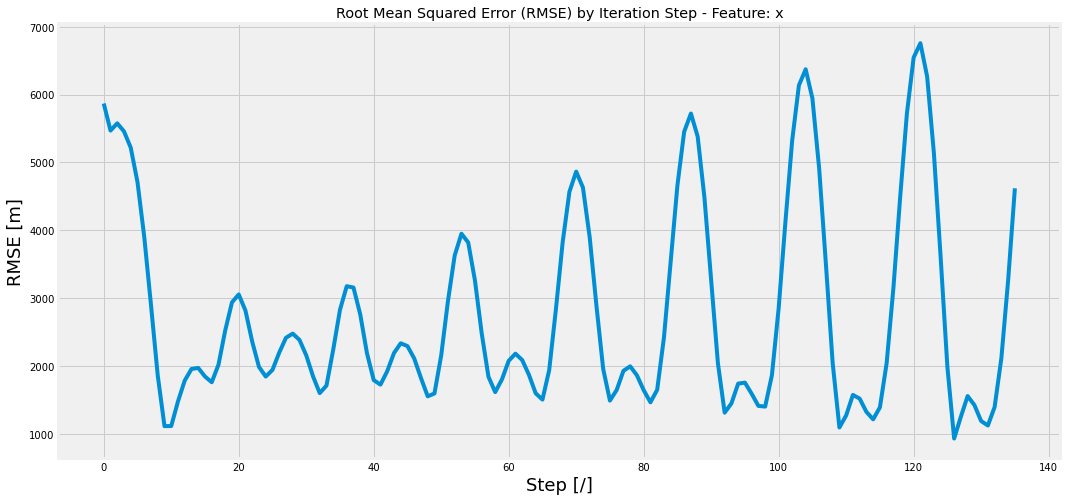

Feature: y


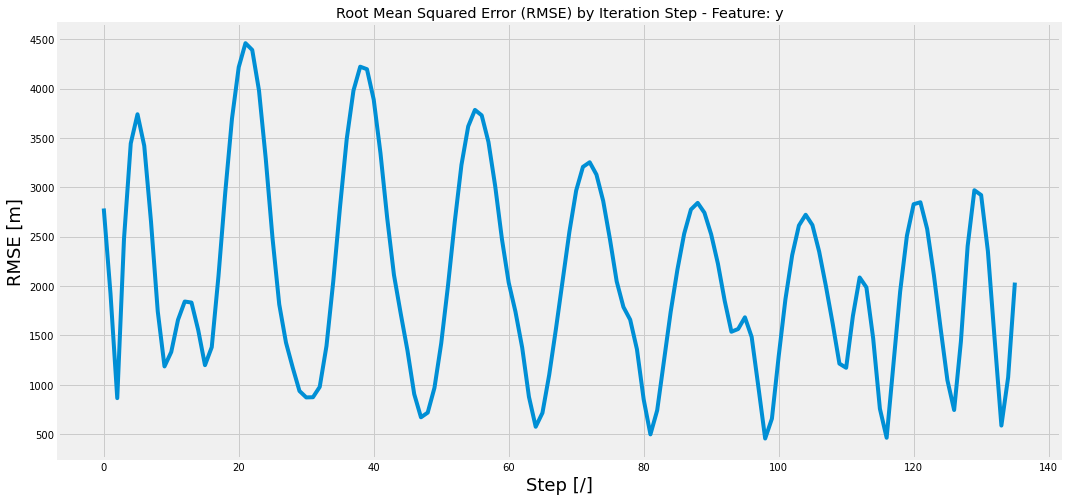

Feature: z


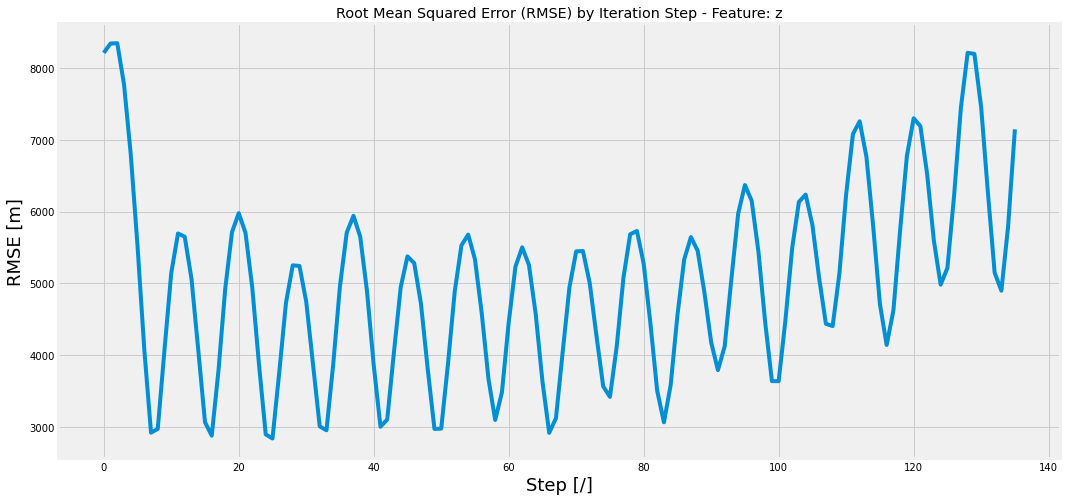

Feature: x_vv


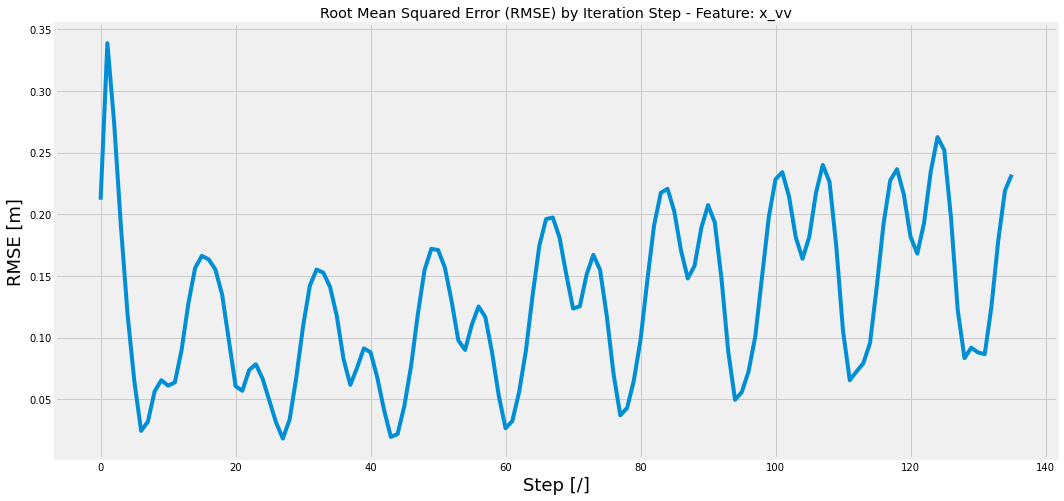

Feature: y_vv


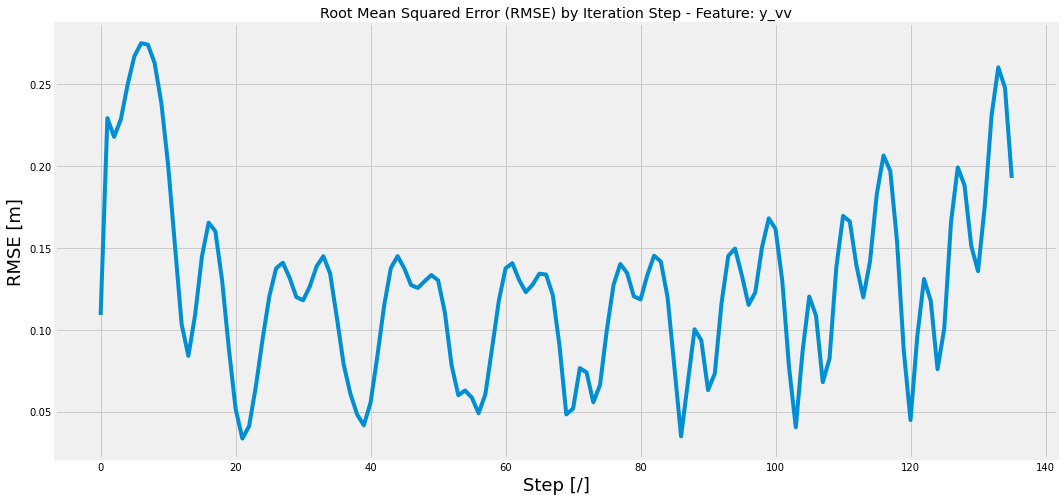

Feature: z_vv


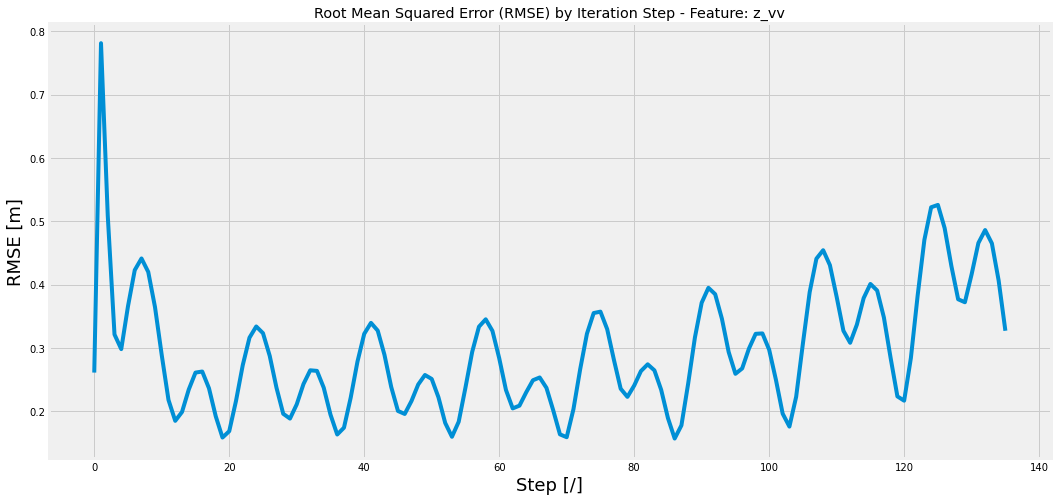

In [43]:
# Plot RMSE vs. steps:

steps = list(range(n_future))

for index,i in enumerate(train_df.columns):
    
    print('Feature: '+str(i))
    rmse = []
    for j in range(0,n_future):
        rmse.append(math.sqrt(mean_squared_error(y_test[:,j-1,index],pred[:,j-1,index])))
    #print(rmse)
    
    #Plots
    plt.figure(figsize=(16,8))
    plt.title('Root Mean Squared Error (RMSE) by Iteration Step - Feature: '+str(i))
    plt.xlabel('Step [/]', fontsize=18)
    plt.ylabel('RMSE [m]', fontsize=18)
    plt.plot(steps, rmse)
    plt.show()

## TF Precision:

## Errors